In [1]:
import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import StratifiedShuffleSplit
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
import keras

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import random


Using TensorFlow backend.


In [2]:
data = pd.read_csv("roundnessdata.csv",skip_blank_lines = False)
train_df = pd.read_csv("traindata.csv",skip_blank_lines = False)
test_df = pd.read_csv("testdata.csv")

In [3]:
matrix = np.zeros((data.shape[0],60))
vector = np.transpose(data.iloc[:,1:241])
#sc = StandardScaler() 
#vector = sc.fit_transform(vector) 
vector = vector.values.reshape(4,60,data.shape[0])
pca = PCA(1) 
#pca.fit(np.transpose(vector[:,:,0])) 

In [4]:
for i in range(0,vector.shape[2]):
    matrix[i,:]=np.transpose(pca.fit_transform(np.transpose(vector[:,:,i])))

In [143]:
matrix

array([[ 1.32255871, -0.06030202,  0.01822003, ..., -0.02226846,
        -0.02216491, -0.02262753],
       [ 1.25017052, -0.05546775,  0.01833256, ..., -0.02270048,
        -0.02279509, -0.02260737],
       [ 1.38026732, -0.02543734, -0.02005259, ..., -0.02459542,
        -0.02413666, -0.02416974],
       ...,
       [ 1.35052002, -0.02228895, -0.00906619, ..., -0.0230184 ,
        -0.02313439, -0.02290019],
       [ 1.17384193, -0.02307961,  0.05204913, ..., -0.0216569 ,
        -0.02157408, -0.02164629],
       [ 1.30870694, -0.02442734,  0.00625409, ..., -0.02273686,
        -0.02267534, -0.02280597]])

<function matplotlib.pyplot.show(*args, **kw)>

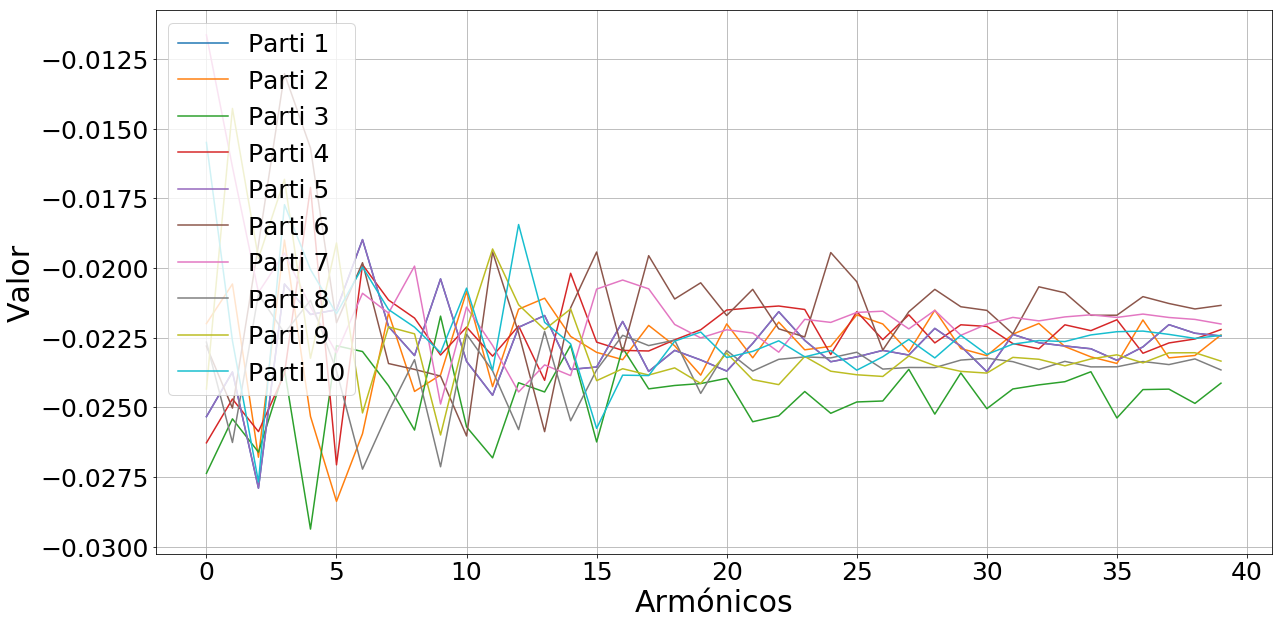

In [6]:
plt.figure(figsize=(20,10)) 
#range(test_res['predicted'].shape[0],0,-1)
plt.plot(matrix[0,10:50], label="Parti 1") 
plt.plot(matrix[1,10:50], label="Parti 2") 
plt.plot(matrix[2,10:50], label="Parti 3") 
plt.plot(matrix[3,10:50], label="Parti 4") 
plt.plot(matrix[4,10:50], label="Parti 5") 
plt.plot(matrix[5,10:50], label="Parti 6") 
plt.plot(matrix[6,10:50], label="Parti 7") 
plt.plot(matrix[7,10:50], label="Parti 8") 
plt.plot(matrix[8,10:50], label="Parti 9") 
plt.plot(matrix[9,10:50], label="Parti 10") 
plt.rc('legend', fontsize=25) 
plt.ylabel('Valor', fontsize=30) 
plt.xlabel('Armónicos', fontsize=30) 
plt.legend(loc="upper left")

#plt.title("Resultado del entrenamiento de la red neuronal profunda",fontsize=35) 
plt.xticks(size = 25) 
plt.yticks(size = 25) 
plt.grid(True) 
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

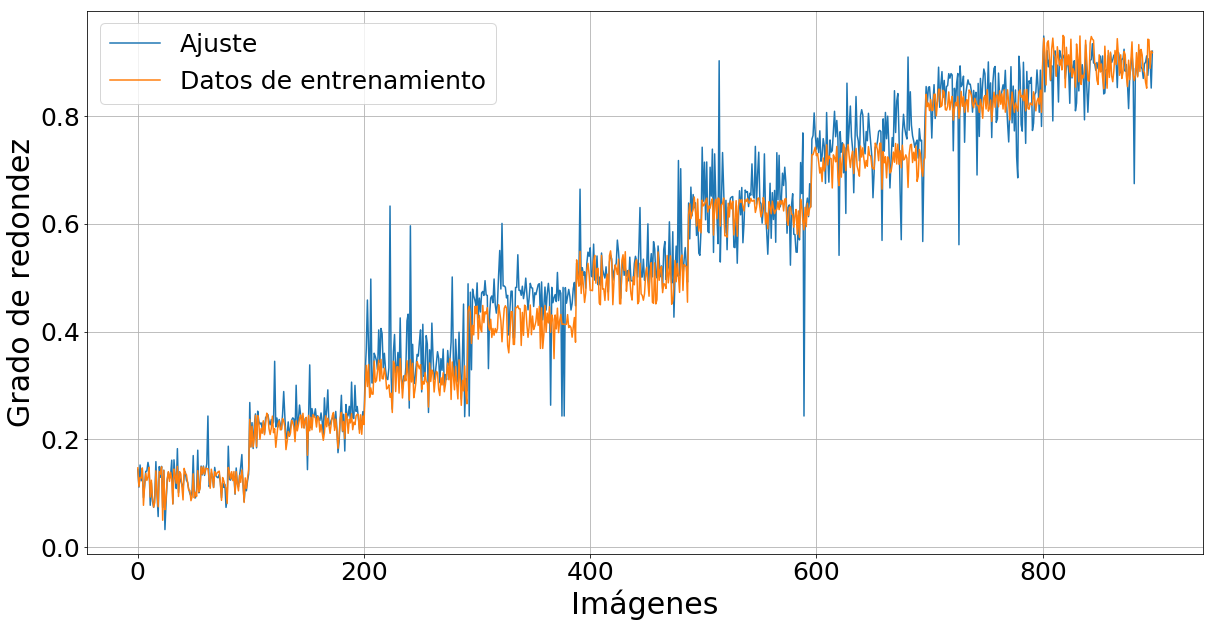

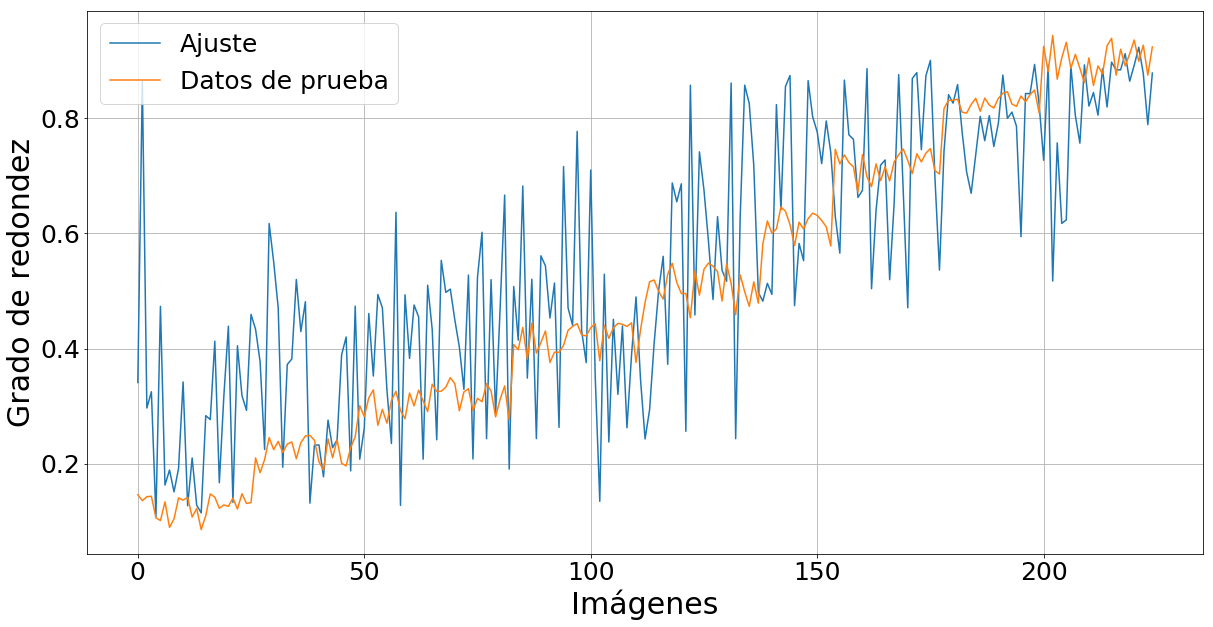

In [142]:
#lim_inf = 1
#lim_sup = 242
#neuronas = 10 
#train_x = data.iloc[:,lim_inf:lim_sup]

train_y = data.iloc[:,0:1]
#np.r_[661:848,0:98]
#train_x = train_df.iloc[:,lim_inf:lim_sup]

#train_y = train_df.iloc[:,0:1]
#np.r_[214:275,0:27]
#test_x = test_df.iloc[:,lim_inf:lim_sup]

#test_y = test_df.iloc[:,0:1]

train_x, test_x, train_y, test_y = train_test_split(matrix[:,5:40], train_y, test_size=0.2)

sc = StandardScaler() 
train_x = sc.fit_transform(train_x) 
test_x = sc.transform(test_x)

n_cols = train_x.shape[1] 
model = Sequential() 
model.add(Dense(100, activation="relu", input_shape=(n_cols,))) 
model.add(Dense(200,activation="relu")) 
model.add(Dense(300,activation="relu")) 
model.add(Dense(400,activation="relu")) 
model.add(Dense(500,activation="relu")) 
model.add(Dense(600,activation="relu")) 
model.add(Dense(1,activation="linear")) 
opt = keras.optimizers.RMSprop( learning_rate=.002)

#my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate) 
model.compile(optimizer=opt, loss='mae',metrics=['mae','mse','mape','cosine'])

#set early stopping monitor so the model stops training when it won't improve anymore 
early_stopping_monitor = EarlyStopping(patience=5,monitor='loss')

#train model #,callbacks=[early_stopping_monitor]
model.fit(train_x,train_y,validation_data = (test_x,test_y),callbacks=[early_stopping_monitor], epochs=300,verbose=0)

##Train

train_y = train_y.reset_index().sort_values('index')

train_x = train_x[train_y.index]

train_y = train_y.reset_index()

ynew = model.predict(train_x) 
diff = abs(ynew - train_y) 
dummy_y = train_y 
dummy_y['predicted'] = ynew 
mse = mean_squared_error(dummy_y['roundness'], dummy_y['predicted']) 
me = statistics.stdev(dummy_y['predicted'])/math.sqrt(dummy_y['predicted'].shape[0]) 
fig0 = plt.figure(0,figsize=(20,10)) 
#range(dummy_y['predicted'].shape[0],0,-1),
plt.plot(dummy_y['predicted'].sort_index(), label="Ajuste") 
plt.plot(dummy_y['roundness'].sort_index(), label="Datos de entrenamiento") 
plt.rc('legend', fontsize=25) 
plt.ylabel('Grado de redondez', fontsize=30) 
plt.xlabel('Imágenes', fontsize=30) 
plt.legend(loc="upper left")

#plt.title("Resultado del entrenamiento de la red neuronal profunda",fontsize=35)
plt.xticks(size = 25) 
plt.yticks(size = 25) 
plt.grid(True)
plt.show 
plt.savefig('redondezComparacion.png')

##Test

test_res = test_y 

test_res = test_res.reset_index().sort_values('index') 
test_x = test_x[test_res.index]

#test_x = test_x.reset_index()

#test_x = test_x.iloc[:,1:test_x.shape[1]] 
test_res = test_res.reset_index() 
ynew = model.predict(test_x) 
diff = abs(ynew - test_y) 
test_res['predicted'] = ynew 
mse = mean_squared_error(test_res['roundness'], test_res['predicted']) 
me = statistics.stdev(test_res['predicted'])/math.sqrt(test_res['predicted'].shape[0]) 
plt.figure(figsize=(20,10)) 
#range(test_res['predicted'].shape[0],0,-1)
plt.plot(test_res['predicted'].sort_index(), label="Ajuste") 
plt.plot(test_res['roundness'].sort_index(), label="Datos de prueba") 
plt.rc('legend', fontsize=25) 
plt.ylabel('Grado de redondez', fontsize=30) 
plt.xlabel('Imágenes', fontsize=30) 
plt.legend(loc="upper left")

#plt.title("Resultado del entrenamiento de la red neuronal profunda",fontsize=35) 
plt.xticks(size = 25) 
plt.yticks(size = 25) 
plt.grid(True) 
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

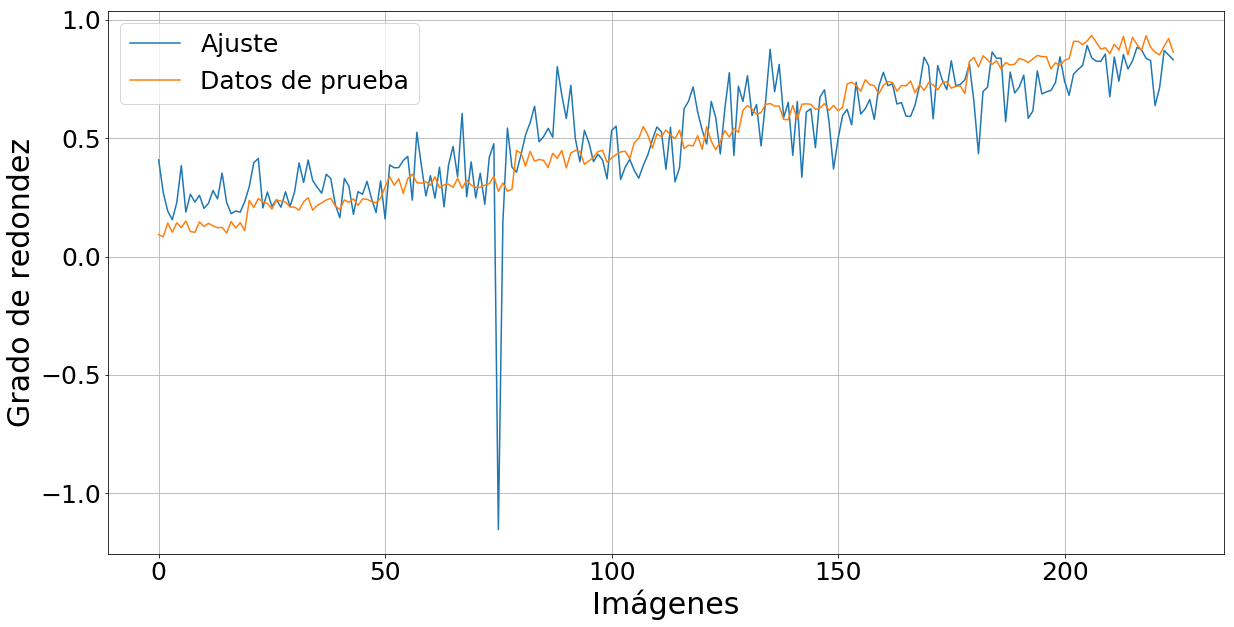

In [426]:
##Test

test_res = test_y
test_res = test_res.reset_index().sort_values('index')
test_x = test_x[test_res.index]
test_res = test_res.reset_index()
ynew = model.predict(test_x)
diff = abs(ynew - test_y)
test_res['predicted'] = ynew
mse = mean_squared_error(test_res['roundness'], test_res['predicted'])
me = statistics.stdev(test_res['predicted'])/math.sqrt(test_res['predicted'].shape[0])
plt.figure(figsize=(20,10))
plt.plot(test_res['predicted'].sort_index(), label="Ajuste")
plt.plot(test_res['roundness'].sort_index(), label="Datos de prueba")
plt.rc('legend', fontsize=25)
plt.ylabel('Grado de redondez', fontsize=30)
plt.xlabel('Imágenes', fontsize=30)
plt.legend(loc="upper left")
#plt.title("Resultado del entrenamiento de la red neuronal profunda",fontsize=35)
plt.xticks(size = 25)
plt.yticks(size = 25)
plt.grid(True)
plt.show

C:\Users\HeavyRain350\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


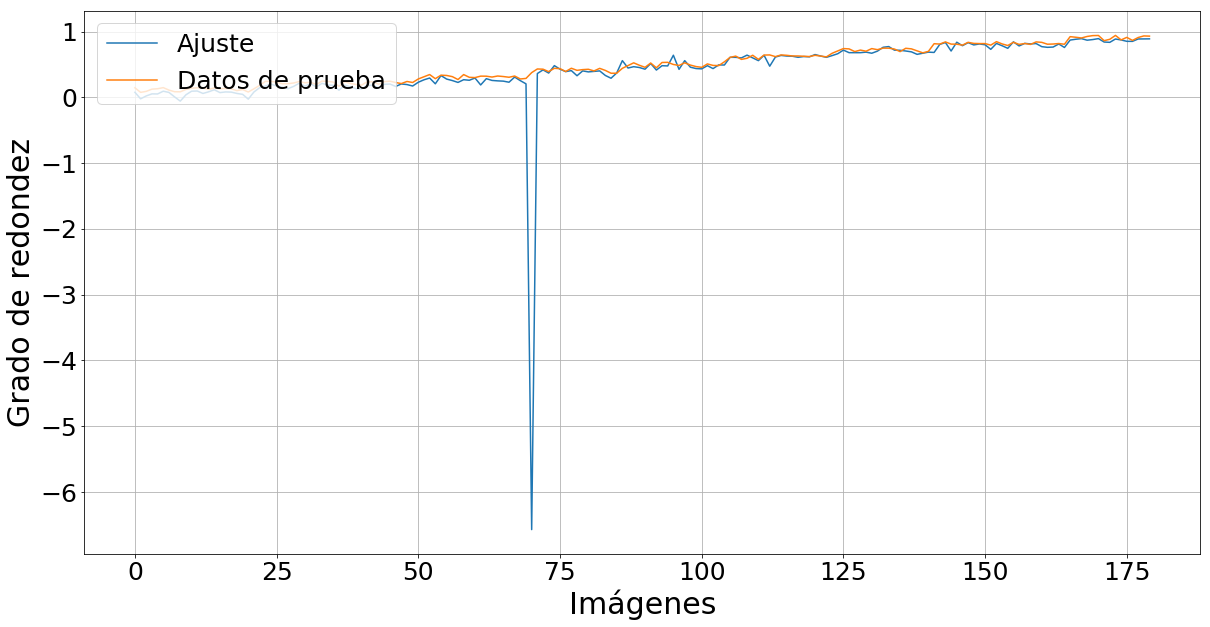

In [464]:
train_x2 = train_x[::5, :]
train_y2 = train_y.iloc[::5,:]
train_y2 = train_y2.reset_index().sort_values('index')
train_x2 = train_x2[train_y2.index]
train_y2 = train_y2.reset_index()
#train_y2 = train_y2.reset_index()
ynew = model.predict(train_x2)
diff = abs(ynew - train_y2)
dummy_y2 = train_y2
dummy_y2['predicted'] = ynew
mse2 = mean_squared_error(dummy_y2['roundness'], dummy_y2['predicted'])
me2 = statistics.stdev(dummy_y2['predicted'])/math.sqrt(dummy_y2['predicted'].shape[0])

figTest=plt.figure(1,figsize=(20,10))
plt.plot(dummy_y2['predicted'].sort_index(), label="Ajuste")
plt.plot(dummy_y2['roundness'].sort_index(), label="Datos de prueba")
plt.rc('legend', fontsize=25)
plt.ylabel('Grado de redondez', fontsize=30)
plt.xlabel('Imágenes', fontsize=30)
plt.legend(loc="upper left")
#plt.title("Resultado del entrenamiento de la red neuronal profunda",fontsize=35)
plt.xticks(size = 25)
plt.yticks(size = 25)
plt.grid(True)
figTest.show()
figTest.savefig('redondezTesting.png')


In [496]:
train_y2=train_y2.reset_index().sort_values('index')

In [501]:
train_y2

,index,roundness,predicted
71,0,0.147144,0.135400
42,3,0.077683,0.072275
24,13,0.135743,0.141120
15,19,0.143410,0.132731
165,21,0.105966,0.108787
96,28,0.089833,0.077534
120,45,0.140080,0.144986
97,49,0.146276,0.145260
101,62,0.122222,0.117849
81,72,0.135640,0.134468


In [386]:
mse
#Error cuadratico medio

0.029263216089917058

In [387]:
me
#Error promedio o estándar

0.017883638095856524

In [388]:
abEr = abs(dummy_y['roundness']-dummy_y['predicted'])

In [419]:
set1 = abEr[abEr < 0.01]
porc = 100*set1.shape[0]/abEr.shape[0]
porc

42.42761692650334

In [420]:
set1 = abEr[abEr < 0.02]
porc = 100*set1.shape[0]/abEr.shape[0]
porc

67.48329621380846

In [421]:
set1 = abEr[abEr < 0.05]
porc = 100*set1.shape[0]/abEr.shape[0]
porc

91.0913140311804

In [423]:
set1 = abEr[abEr < 0.08]
porc = 100*set1.shape[0]/abEr.shape[0]
porc

96.88195991091314

In [424]:
set1 = abEr[abEr < 0.09]
porc = 100*set1.shape[0]/abEr.shape[0]
porc

97.55011135857461

In [422]:
set1 = abEr[abEr < 0.1]
porc = 100*set1.shape[0]/abEr.shape[0]
porc

98.21826280623608

In [452]:
dummy_y


,roundness,predicted
210,0.211329,0.219201
704,0.620382,0.609260
705,0.590895,0.572035
877,0.830665,0.805237
663,0.578033,0.659726
462,0.448553,0.400879
718,0.643433,0.638363
1095,0.903000,0.860226
234,0.218078,0.207795
1065,0.851000,0.807937


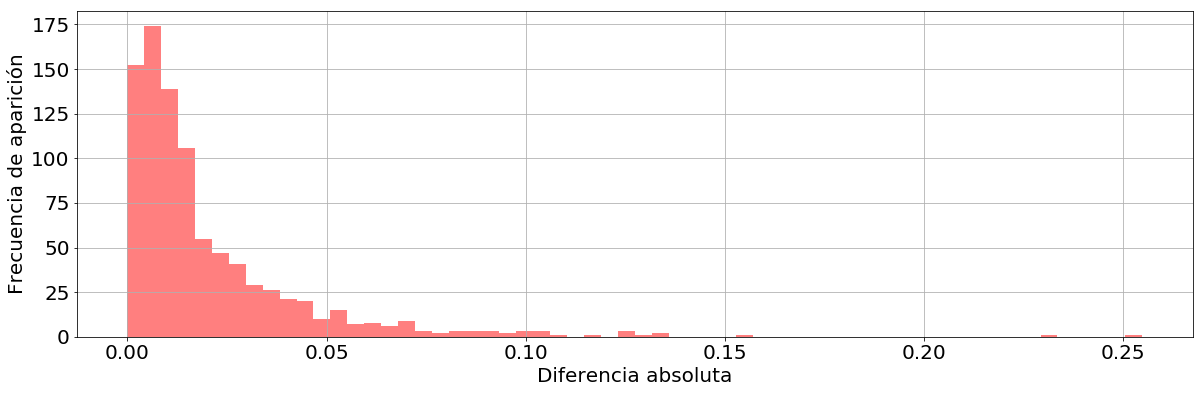

In [506]:
fig=plt.figure(figsize=(20,6))
n, bins, patches = plt.hist(abEr, 60, facecolor='red', alpha=0.5)

# add a 'best fit' line
plt.xlabel('Diferencia absoluta', fontsize=20)
plt.ylabel('Frecuencia de aparición', fontsize=20)

# Tweak spacing to prevent clipping of ylabel
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(True)
#plt.title("Histograma del error absoluto",fontsize=28)
plt.show()
fig.savefig('histogramaError.png')

In [504]:
#Error cuadratico medio
mse2

0.0011868462656432707

In [505]:
#Error estandar o promedio
me2

0.01929572372362336